In [1]:
from smap.archiver.client import SmapClient                                                                                                                                                                                                                                                                                   
from smap.contrib import dtutil                                                                                                                                                                                                                                                                                               
import json                                                                                                                                                                                                                                                                                                                   
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
import sys
import numpy as np
import itertools
from datetime import datetime
from functools import reduce
np.set_printoptions(precision=3)
%matplotlib inline

In [2]:
# fetch data
c = SmapClient("http://new.openbms.org:8079")
print c
uuid_file = "SDH_floor_4_temperature_uuids.json"
start_time = dtutil.dt2ts(dtutil.strptime_tz("10-30-2016", "%m-%d-%Y"))
end_time = dtutil.dt2ts(dtutil.strptime_tz("11-30-2016", "%m-%d-%Y"))
                                                                                                                                                                                                                                                                                                                              
print uuid_file                                                                                                                                                                                                                                                                                                               
uuids = json.load(open(uuid_file))
data = c.data_uuid(uuids, start_time, end_time,limit=10000)

<smap.archiver.client.SmapClient instance at 0x7fb1a61cc098>
SDH_floor_4_temperature_uuids.json

downloaded 1584b from 24 urls in 0.817s (0.002MB/s download: 0.817s, parse: 0.000808s)


In [3]:
metadata_file = 'SDH_floor_4_metadata.json'
_metadata = json.load(open(metadata_file))
sensor_metadata = {}
for doc in _metadata:
    sensor_metadata[doc['uuid']] = doc
    sensor_metadata[doc['Metadata']['Instrument']['PartNumber']] = doc

# grab VAV metadata
_metadata = c.query("select * where Metadata/SourceName = 'Sutardja Dai Hall BACnet' and Path ~ '.*ROOM_TEMP' and Metadata/Extra/Vav ~ 'S4.*'")
print _metadata[0]
vav_metadata = {}
for doc in _metadata:
    vavid = doc['Metadata']['Extra']['Vav']
    room = doc['Description'].split(' ')[0]
    uuid = doc['uuid']
    insert = {
            'VAV': vavid,
            'Room': room,
            'uuid': uuid,
        }
    vav_metadata[vavid] = insert
    vav_metadata[room] = insert
    vav_metadata[uuid] = insert

def uuid_to_ketiid(uuid):
    return sensor_metadata[uuid]['Metadata']['Instrument']['PartNumber']
def ketiid_to_vavid(ketiid):
    vav = sensor_metadata[ketiid]['Metadata']['Extra']['VAV']
    print ketiid, vav
    

{'Path': '/Siemens/SDH.PXCM-11/SDH/S4-19/ROOM_TEMP', 'uuid': 'a7aad37c-6dd8-5252-8443-65471582f8e9', 'Metadata': {'SourceName': 'Sutardja Dai Hall BACnet', 'Location': {'Building': 'Sutardja Dai Hall', 'Campus': 'UCB'}, 'PointName': 'SDH.S4-19:ROOM TEMP', 'Extra': {'Type': 'room temperature', 'Vav': 'S4-19'}}, 'Properties': {'Timezone': 'America/Los_Angeles', 'UnitofMeasure': 'F', 'ReadingType': 'double'}, 'Description': '477 WOMENS BATH'}


In [4]:
# build data frames
temperatures = {}
for uuid, datas in zip(uuids, data):             
    if len(datas) == 0: continue
    df = pd.DataFrame.from_records(datas)
    df = df.set_index(pd.to_datetime(df.pop(0), unit='ms'))
    df = df.resample('5min').mean()
    df.columns = [int(uuid_to_ketiid(uuid))]
    temperatures[uuid] = df
    print uuid, df.count()

0bfbd947-40a2-5454-a352-1375790c604d 1707    4763
dtype: int64
19dac044-e8ae-5ed4-a789-a46d2cd9d375 1709    7964
dtype: int64
1f17fd93-8009-5153-926f-54395c421d93 1715    162
dtype: int64
27e71c02-6a7c-5d29-9d7e-3b437f9f6c46 1706    6128
dtype: int64
2a756197-f1b3-56eb-ab87-a61111bdd80b 1624    438
dtype: int64
2e22715f-9d3e-5c5d-b90c-8b6226e29cca 1712    7975
dtype: int64
31e75b66-41bf-518d-a144-f3e144f396e5 1713    7978
dtype: int64
3d4496b0-63e8-5d88-890a-cbce6f1202a6 1716    7977
dtype: int64
41d4673c-0926-5c58-91a3-7c440ed6962c 1631    1854
dtype: int64
4fa00ebf-6387-5183-b987-2b54e1031ec4 1627    4278
dtype: int64
6b0b7685-fd48-5d27-840c-d730ed6681d7 1628    688
dtype: int64
6d03bfef-f70e-5c58-953c-d9b52c41835c 1632    2969
dtype: int64
9165f400-355d-506a-8afa-421273d02010 1702    409
dtype: int64
a988771e-b6c8-5b2e-9c23-ad88e5efe3e6 1630    377
dtype: int64
c796ac06-e7fc-5127-b105-ebc3101a43be 1622    7954
dtype: int64
d0184967-52c2-5c3f-ad90-6e49f10faa7e 1629    7974
dtype: int

In [5]:
print len(temperatures)

16


8600


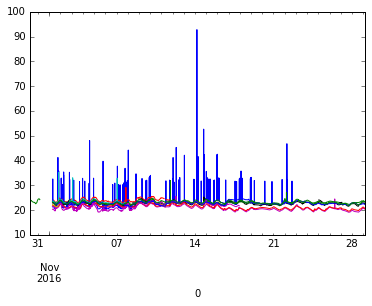

In [6]:
# merge all timeseries into the same data frame
dfs = temperatures.values()
current = dfs[0]
for df in dfs[1:]:
    current = current.merge(df, how='outer',left_index=True, right_index=True)
print len(current)
current.plot(legend=False)

[(42, 53), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (39, 40), (40, 41), (41, 42), (30, 43), (31, 44), (32, 45), (33, 46), (35, 47), (35, 48), (37, 49), (37, 50), (40, 51), (40, 52)]
13


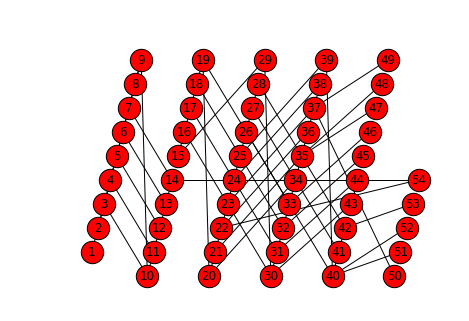

In [16]:
# Generate the SDH graph
nodes = range(1,55) # 1 - 54
sdh_graph_edges = [
    (1,8),
    (8,9),
    (9,2),
    (9,10),
    (10,3),
    (10,11),
    (11,4),
    (11,12),
    (12,5),
    (12,13),
    (13,6),
    (13,14),
    (14,7),
    (14,54),
    (54,22),
    (15,16),
    (16,17),
    (17,18),
    (18,19),
    (19,20),
    (20,21),
    (21,22),
    (22,23),
    (23,24),
    (24,25),
    (25,26),
    (26,27),
    (27,28),
    (42,53),
    (15,29),
    (29,30),
    (30,31),
    (31,32),
    (32,33),
    (33,34),
    (34,35),
    (35,36),
    (36,37),
    (37,38),
    (39,40),
    (40,41),
    (41,42),
    (16,30),
    (17,31),
    (18,32),
    (19,33),
    (20,34),
    (21,35),
    (22,36),
    (23,37),
    (24,38),
    (25,39),
    (26,40),
    (27,41),
    (28,42),
    (30,43),
    (31,44),
    (32,45),
    (33,46),
    (35,47),
    (35,48),
    (37,49),
    (37,50),
    (40,51),
    (40,52)
]
G = nx.Graph()
G.add_edges_from(sdh_graph_edges)
pos = nx.spring_layout(G, iterations=500, k=2.0, scale=10.0)
pos = dict((n,(n, n%10+1)) for n in G.nodes())
nx.draw(G,pos,node_size=500,with_labels=True)
# mapping of sensors to microzones (nodes):
keti_mapping = {
    1711: 1,
    1712: 2,
    1713: 3,
    1714: 4,
    1715: 5,
    1716: 6,
    1717: 12,
    1718: 13,
    1719: 14,
    1632: 16,
    1631: 21,
    1630: 28,
    1621: 30,
    1622: 31,
    1624: 35,
    1625: 38,
    1626: 39,
    1627: 40,
    1628: 41,
    1629: 42,
    1708: 43,
    1707: 44,
    1706: 45,
    1705: 46,
    1704: 47,
    1703: 48,
    1701: 49,
    1702: 50,
    1709: 51,
}
sub_graph_nodes = [30,31,32,33,34,35,36,37,38,39,40,41,42,49,50,51,52,53,43,44,45,46,47,48]
sub_graph_edges = [e for e in sdh_graph_edges if e[0] in sub_graph_nodes and e[1] in sub_graph_nodes]
print sub_graph_edges
import scipy.io
A = nx.adjacency_matrix(G).todense()
scipy.io.savemat('sdh_adjacency.mat', {'A': A})
subG = nx.Graph()
subG.add_edges_from(sub_graph_edges)
A = nx.adjacency_matrix(subG).todense()
scipy.io.savemat('sub_sdh_adjacency.mat', {'A': A})

sdh_offices_1_nodes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
sdh_offices_1_edges = [e for e in sdh_graph_edges if e[0] in sdh_offices_1_nodes and e[1] in sdh_offices_1_nodes]
# normalize edges
subG = nx.Graph()
subG.add_edges_from(sdh_offices_1_edges)
nodes = subG.nodes()
minNode = min(nodes)
edges = subG.edges()
edges = [(nodes.index(x)+1,nodes.index(y)+1) for (x,y) in edges]
e = np.array(edges, dtype=object)
print len(e)
scipy.io.savemat('sdhofficesGedges.mat',{'edges': e})

In [8]:
# normalize edges
nodes = subG.nodes()
minNode = min(nodes)
edges = subG.edges()
edges = [(nodes.index(x)+1,nodes.index(y)+1) for (x,y) in edges]
e = np.array(edges, dtype=object)
print e
scipy.io.savemat('subGedges.mat',{'edges': e})

# normalize edges
nodes = G.nodes()
minNode = min(nodes)
edges = G.edges()
edges = [(nodes.index(x)+1,nodes.index(y)+1) for (x,y) in edges]
e = np.array(edges, dtype=object)
print len(e)
scipy.io.savemat('Gedges.mat',{'edges': e})

[[1 2]
 [2 8]
 [2 9]
 [2 3]
 [4 5]
 [5 6]
 [5 10]
 [5 11]
 [6 7]
 [7 12]]
65


In [9]:
# want to rename the data columns in terms of which node in the graph they are
# also need data for all of the nodes: "easiest" way is to take average of temperatures of nearby nodes
# This is what gets put in 'sdh_idea1.csv'

# First take our empirical data and replace the keti ids with the node ids
current = current.rename(columns=keti_mapping)
# Now we need to "fill" the graph: For each node for which we have original data (make this list at the beginning),
# we do a breadth-first traversal through the tree. At each node we visit, its temperature becomes the average of
# its neighboring nodes; if the node's neighbors do not have any values, then we just use the value we are
# propagating from; if the node already has a value (that's not an empirical value), then its new value is the
# average of its new temperature and its neighbors (using the propagating value if neighbors have no values)
empirical_nodes = current.columns
data_row = current.iloc[0]
result = pd.DataFrame()
rownum = 0
t = datetime.now()
for row in current.iterrows():
    rownum += 1
    for en in empirical_nodes:
        data_row = row[1]
        if pd.isnull(data_row[en]):
            #print en,'has no data'
            continue
        propagate_point = data_row[en]
        bfs_edges = nx.algorithms.traversal.bfs_edges(G, en)
        # the 2nd item (index 1) of each edge is the next node
        bfs_nodes = [x[1] for x in bfs_edges if x[1] not in empirical_nodes or pd.isnull(data_row[x[1]])]
        for node in bfs_nodes:
            neighbors = G.neighbors(node)
            # get data from neighbors
            datas = [data_row.get(n, propagate_point) for n in neighbors]
            # get data from ourself
            datas.append(data_row.get(node, propagate_point))
            # filter out nans
            datas = filter(lambda x: not pd.isnull(x), datas)
            data_row[node] = np.mean(datas)
    if rownum % 1000 == 0:
        print rownum, len(current), (datetime.now()-t).total_seconds()
        t = datetime.now()
    result = result.append(data_row)

1000 8600 49.111135
2000 8600 72.974783
3000 8600 72.245152
4000 8600 72.475041
5000 8600 73.446495
6000 8600 73.134048
7000 8600 70.543662
8000 8600 59.268786


In [10]:
result.head()

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
2016-10-30 07:00:00,23.820500,23.820500,23.820500,23.820500,23.820500,23.820500,23.820500,23.820500,23.820500,23.820500,...,23.820500,23.820500,23.820500,23.820500,23.820500,23.820500,23.820500,23.820500,23.820500,23.820500
2016-10-30 07:05:00,23.819833,23.819833,23.819833,23.819833,23.819833,23.819833,23.819833,23.819833,23.819833,23.819833,...,23.819833,23.819833,23.819833,23.819833,23.819833,23.819833,23.819833,23.819833,23.819833,23.819833
2016-10-30 07:10:00,23.812833,23.812833,23.812833,23.812833,23.812833,23.812833,23.812833,23.812833,23.812833,23.812833,...,23.812833,23.812833,23.812833,23.812833,23.812833,23.812833,23.812833,23.812833,23.812833,23.812833
2016-10-30 07:15:00,23.805167,23.805167,23.805167,23.805167,23.805167,23.805167,23.805167,23.805167,23.805167,23.805167,...,23.805167,23.805167,23.805167,23.805167,23.805167,23.805167,23.805167,23.805167,23.805167,23.805167
2016-10-30 07:20:00,23.793667,23.793667,23.793667,23.793667,23.793667,23.793667,23.793667,23.793667,23.793667,23.793667,...,23.793667,23.793667,23.793667,23.793667,23.793667,23.793667,23.793667,23.793667,23.793667,23.793667


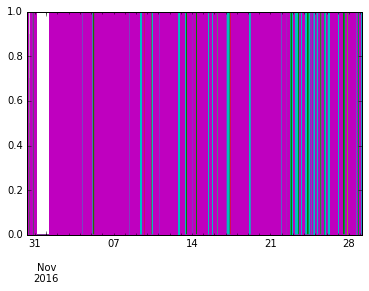

In [14]:
# compute whether or not temperature going up or not
df = result.copy()
diffs = df.interpolate(method='time').diff(axis=0)
diffs[diffs > 0] = 1
diffs[diffs < 0] = 0
diffs = diffs.fillna(0)
diffs.plot(legend=False)
diffs.tail()
diffs.to_csv("idea1.csv",sep="\t",header=False,index=False)
diffs.to_csv("idea1mat.csv",sep="\t",header=False,index=False)

In [15]:
sdh_office_data = data[sdh_offices_1_nodes]
sdh_office_data.to_csv("sdh_office_data.csv",sep="\t",header=False,index=False)

In [12]:
class Table(object):
    def __init__(self, matrix, nodes):
        """
        matrix is an {MxMx...} matrix, with # dimensions equal to the # of nodes
        nodes is a (sorted) list of the nodes on the edge
        """
        self.matrix = matrix
        self.nodes = nodes
    def fetch(self, idx):
        """
        idx is a dict of (node: nodestate) that we want to use to fetch a value
        from our matrix. We will only have 2 of them.
        If we don't have both nodes, then we return 1
        """
        # fetch node names
        nodes = idx.keys()
        ours = set(nodes).intersection(self.nodes)
        ours = sorted(list(ours))
        if len(ours) != len(self.nodes):
            return 1
        return self.matrix[tuple([idx[i] for i in ours])]
    def marginalize(self, target):
        """
        Sum over all dimensions that aren't the dimension of [target]
        Target is a tuple of nodes
        """
        res = self.matrix
        num = 0
        for idx, node in enumerate(self.nodes):
            if node in target: continue
            res = np.sum(res, axis=idx-num)
            num += 1
        return res / np.sum(res)


def multiply_edge(e1,e2):
    """
    Multiplies 2 tables together, as part of a graph factorization.
    Returns a new edge with nodes = set(e1.nodes).union(set(e2.nodes)), and matrix
    with dimensions equal to the number of nodes in the new set
    """
    nodes = list(set(e1.nodes).union(set(e2.nodes)))
    states = itertools.product([0,1],repeat=len(nodes))
    result = np.zeros([2]*len(nodes))
    for state in states:
        # creates a list of (node, nodestate) for indexing into an edge and
        # retrieving the probability
        idx = dict(zip(nodes, state))
        result[(state)] = e1.fetch(idx) * e2.fetch(idx)
    return Table(result, nodes)

class Graph(object):
    def __init__(self, data, edges):
        self.data = data
        self.edges = edges

    def compute_factorization(self):
        return reduce(multiply_edge, self.edges)

    def get_empirical_marginals(self, nodelist):
        """
        nodelist is a list of numbers (i,j,k...) that we want to get the joint empirical distribution of
        df is a DataFrame w/ column names = the node names, and each column is a set of samples

        Result is a MxM matrix where M is the number of states
idea1
        Right now, assume binary variables
        """
        df = self.data
        # create the {MxMx...} matrix; the dimensionality is equal to the number of nodes in the list
        result = np.zeros([2]*len(nodelist))
        # create the list of all possible binary states of the N nodes
        states = itertools.product([0,1],repeat=len(nodelist))
        # for each of these states
        for state in states:
            # create the list of conditions (e.g. a selector into the dataframe that retrieves the rows where the state is true)
            # for example, each state is something like (0,1,0); for a nodelist of (1,2,3), we create a list of
            # (df[1] == 0) & (df[2] == 1) & (df[3] == 0). The creation of the list is done by this line; the compositiion
            # of these statements into a single condition is the next line
            cond = [(df[node] == val) for node, val in zip(nodelist, state)]
            # combine the states into a single condition
            cond = np.bitwise_and.reduce(cond)
            # df[cond].count() returns the number of rows that match all conditions
            avg = (df[cond].count() / df.count()).iloc[0]
            # assign into the matrix
            result[state] = avg
        return result

    def update_model_params(self, edge, matrix):
        """
        Updates the compat matrix for the given edge
        edge is a list of nodes (i,j,...)
        matrix is an {MxM...} matrix
        """
        for idx, e in enumerate(self.edges):
            if e == edge:
                self.edges[idx] = matrix
                break

    def get_compat_for_edge(self, edge):
        """
        edge is a list of nodes (i,j,...)
        Returns the matrix for the corresponding edge
        """
        for e in self.edges:
            if e == edge:
                return e

    def dump(self):
        res = ""
        for e in self.edges:
            res += '\nEdge {0} => {1}'.format(e.nodes, str(e.matrix).replace('\n','\n\t\t'))
        return res

    def compute_likelihood(self):
        empiricals = self.get_empirical_marginals(list(self.data.columns))
        factor = self.compute_factorization()
        print empiricals.flatten()
        print factor.matrix.flatten()
        return np.inner(empiricals.flatten(), factor.matrix.flatten())

    def compute_likelihood_edges(self):
        factor = self.compute_factorization()
        likelihood = 0
        for row in self.data.itertuples():
            row = np.array(row[1:]) # skip the first entry because its the index
            likelihood += factor.matrix[tuple(row)]
        return likelihood

def run(data, edges):
    G = Graph(data, edges)
    print G.data.head()
    old = ""
    print data.columns
    for i in range(1,200):
        for edge in G.edges:
            empirical_mean = G.get_empirical_marginals(edge.nodes)
            factor = G.compute_factorization()
            model_mean = factor.marginalize(edge.nodes)
            model_mean[np.where(np.isnan(model_mean))] = 1
            old_compat = G.get_compat_for_edge(edge)
            proportion = np.divide(empirical_mean, model_mean)
            proportion[np.where(np.isnan(proportion))] = 0
            new = np.multiply(old_compat.matrix, proportion)
            #new = new / np.sum(new) # re-normalize #TODO: remove?
            G.update_model_params(edge, Table(new, edge.nodes))
        new = G.dump()
        if i % 10 == 0:
            print 'run',i
        if new == old:
            print '-'*5,'run',i,'-'*5
            print new
            print 'likelihood',G.compute_likelihood()
            break
        else:
            old = new
    print new

data = np.recfromtxt('idea1.csv')
data = pd.read_csv('idea1.csv',delimiter='\t')
data.columns = map(int, data.columns)

# NOTE: we are using sub_graph_{nodes, edges} here.  Full graph is sdh_graph_{nodes, edges}

sub_data = data[sub_graph_nodes]
sub_data.to_csv("sdh_sub.csv",sep="\t",header=False,index=False)

# want to rename the data columns in terms of which node in the graph they are
# also need data for all of the nodes: "easiest" way is to take average of temperatures of nearby nodes

psi = np.matrix([[1,1],[1,1]])
edges = []
for ge in sub_graph_edges:
    edges.append(Table(psi, ge))
run(sub_data, edges)


ValueError: invalid literal for int() with base 10: '0.0'

In [ ]:
G.dump()

In [ ]:
# trying out: http://pgmpy.org/estimators.html#maximum-likelihood-estimator
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
model = BayesianModel()
model.add_edges_from(sdh_graph_edges)
data = pd.read_csv('idea1.csv',delimiter='\t')
data.columns = map(int, data.columns)
print sdh_graph_edges
estimator = MaximumLikelihoodEstimator(model, data)
params = estimator.get_parameters()

In [ ]:
for p in params:
    print p

In [ ]:
estimator.node_card

In [ ]:
!ls

In [ ]:
!top -n1